# Project Part 1
## Question 1
### Imports and Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq

ois = pd.read_excel("IR Data.xlsx", sheet_name = 'OIS', usecols = ["Tenor", "Product", "Rate"])

In [2]:
#tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '15y', '20y', '30y']
tenors = ois["Tenor"]

# Define a function to convert tenor strings to years
def tenor_to_years(tenor):
    if 'm' in tenor:
        return int(tenor.replace('m', '')) / 12
    elif 'y' in tenor:
        return int(tenor.replace('y', ''))
    else:
        return None

# Convert each tenor to years
ois["years"] = [tenor_to_years(tenor) for tenor in tenors]

# Add place holder for Discount Factors and cumsum of discount factors
ois[['f', 'cumsum_df','df']] = np.nan
ois

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,NaN,NaN,NaN
1,1y,OIS,0.00300,1.0,NaN,NaN,NaN
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN,NaN
6,7y,OIS,0.00400,7.0,NaN,NaN,NaN
7,10y,OIS,0.00450,10.0,NaN,NaN,NaN
8,15y,OIS,0.00500,15.0,NaN,NaN,NaN
9,20y,OIS,0.00525,20.0,NaN,NaN,NaN


### Solve for year 1 Discount Factor
Use the swap formula where we consider a par swap as the following:
$$
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) = 1 - D(0, T_n) \\
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) - (1 - D(0, T_n))= 0 \tag{1}
$$
Equation (1) can be a function of the unknown discount factor and can be used as objective function. After using Solver to find the root of equation (1), this root is the Discount Factor(df) for that year.

### get f for 0.5 year


In [3]:
f_0 = 360 * ((0.5*.0025+1)**(1/180)-1)
ois.at[0,'f'] = f_0

In [4]:
ois.head()

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,NaN
1,1y,OIS,0.00300,1.0,NaN,NaN,NaN
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN


In [5]:
def payer_ois_swap_1y(f_1, f_0, ois_1y):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR FIRST YEAR ONLY
    paramters:
        f_0: zero rate 0 to .5 years
        f_1: zero rate .5 to 1 years
    """
    D_1 = 1/((1+f_0/360)**180 * (1+f_1/360)**180)

    fix_leg = D_1 * ois_1y
    flt_leg = D_1 * (1/D_1 - 1)

    return fix_leg - flt_leg
    
guess = 0.99

f_1 = fsolve(payer_ois_swap_1y, 
                         guess, 
                         args=(ois.at[0, 'f'],
                               ois.at[1, 'Rate']))[0]
ois.at[1, 'f'] = f_1
ois.at[1, 'df'] = 1/((1+f_0/360)**180 * (1+f_1/360)**180)
ois.cumsum_df = ois.df.cumsum()
ois

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,NaN
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,NaN,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN,NaN
6,7y,OIS,0.00400,7.0,NaN,NaN,NaN
7,10y,OIS,0.00450,10.0,NaN,NaN,NaN
8,15y,OIS,0.00500,15.0,NaN,NaN,NaN
9,20y,OIS,0.00525,20.0,NaN,NaN,NaN


### Solve for 2y to 5y

In [6]:
def D(t,df_ois, f_t):
    """
    Return discount factor
    FOR SECOND YEAR ONWARDS only
    parameters:
        t: maturity in years
        f: zero rate in annual terms for the latest year
    """
    D = 1
    D *= 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180) #instantiate with 1y DF

    for i in range(2,int(t+1)):  # loop year 2 to year t
        f_i = ois.set_index('years')['f'].get(i, f_t)
        if pd.isna(f_i):        # assign the latest f_t if no f value in table
            f_i = f_t
        if f_i > 0:
            D *= 1/((1+f_i/360)**360)       # multiply each year's discount factor
    
    return D

D(2.0,ois,.00350275)

0.9935228259753861

In [7]:
def payer_ois_swap_2y(f_n, df_ois, T):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR SECOND YEAR ONWARDS
    paramters:
        f_n: zero rate n-1 to n years
        df_ois: DataFrame of OIS and f values
        T: maturity of swap
    """
    if T <2:
        return "only for 2 year onwards"
    fix_leg = 0
    flt_leg = 0
    cumsum_df = 0

    D1 = 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180)
    flt_leg += D1 * (1/D1-1)
    cumsum_df += D1

    for i in range(2,int(T+1)):
        f_i = ois.set_index('years')['f'].get(i, f_n)
        if pd.isna(f_i):        # if there is no f value then assign the latest f
            f_i = f_n
        if f_i > 0:
            Di = D(i,ois,f_i)
            flt_leg +=  Di * ((1+f_i/360)**360-1)

        cumsum_df += Di
    
    fix_leg = cumsum_df * df_ois.loc[df_ois['years']==i,'Rate'].values[0] 

    return flt_leg-fix_leg


guess = 0.0035
for i in range(2,11):
    T = ois.loc[i,'years']
    f_i = fsolve(payer_ois_swap_2y, 
                            guess, 
                            args=(ois,
                                    T))[0]
    ois.at[i, 'f'] = f_i
    ois.at[i, 'df'] = D(i,ois,f_i)

    guess = f_i

In [8]:
# fill 0.5 year
ois.at[0,'df'] = 1/(1+f_0/360)**180

ois

,Tenor,Product,Rate,years,f,cumsum_df,df
0,6m,OIS,0.00250,0.5,0.002498,NaN,0.998752
1,1y,OIS,0.00300,1.0,0.003493,0.997009,0.997009
2,2y,OIS,0.00325,2.0,0.003495,NaN,0.993531
3,3y,OIS,0.00335,3.0,0.003545,NaN,0.990015
4,4y,OIS,0.00350,4.0,0.003946,NaN,0.986117
5,5y,OIS,0.00360,5.0,0.003996,NaN,0.982184
6,7y,OIS,0.00400,7.0,0.005003,NaN,0.977283
7,10y,OIS,0.00450,10.0,0.005509,NaN,0.971914
8,15y,OIS,0.00500,15.0,0.005827,NaN,0.965959
9,20y,OIS,0.00525,20.0,0.005908,NaN,0.960114


### Interpolate semi-annual DF and cumsum

In [9]:
# Generate the full sequence
full_sequence = np.arange(0.5, 30.5, 0.5)
# Convert 'years' column of your DataFrame to a list
existing_years = ois['years'].tolist()
# Remove the existing years from the full sequence
new_years = [year for year in full_sequence if year not in existing_years]

additional_years = pd.DataFrame({
    'years': new_years,
    'Rate': [np.nan]*len(new_years),
    'df': [np.nan]*len(new_years)
})
ois = pd.concat([additional_years, ois])
ois = ois.sort_values(by='years')\
        .reset_index(drop=True)
ois['df'] = ois['df'].interpolate(method='linear')
ois['cumsum_df'] = ois['df'].cumsum()

ois.head(10)

,years,Rate,df,Tenor,Product,f,cumsum_df
0,0.5,0.00250,0.998752,6m,OIS,0.002498,0.998752
1,1.0,0.00300,0.997009,1y,OIS,0.003493,1.995761
2,1.5,NaN,0.995270,NaN,NaN,NaN,2.991030
3,2.0,0.00325,0.993531,2y,OIS,0.003495,3.984561
4,2.5,NaN,0.991773,NaN,NaN,NaN,4.976334
5,3.0,0.00335,0.990015,3y,OIS,0.003545,5.966349
6,3.5,NaN,0.988066,NaN,NaN,NaN,6.954415
7,4.0,0.00350,0.986117,4y,OIS,0.003946,7.940532
8,4.5,NaN,0.984150,NaN,NaN,NaN,8.924682
9,5.0,0.00360,0.982184,5y,OIS,0.003996,9.906866


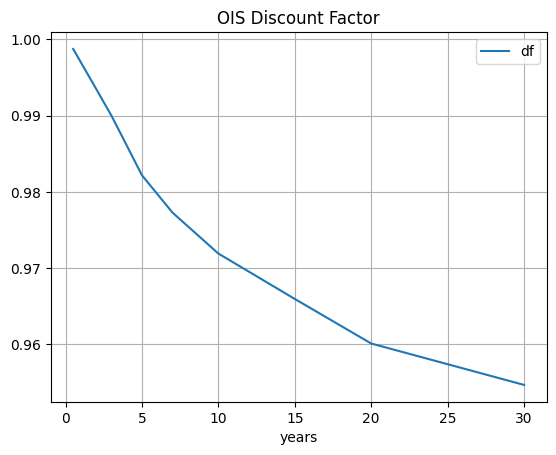

In [10]:
ois.plot(x='years',y='df')
plt.title("OIS Discount Factor")
plt.grid(True)
plt.show()

## Question 2
### Imports and Data Wrangling

In [11]:
irs = pd.read_excel("IR Data.xlsx", sheet_name = 'IRS', usecols = ["Tenor", "Product", "Rate"])
# Convert each tenor to years
irs["years"] = [tenor_to_years(tenor) for tenor in tenors]
# Convert 'years' column of your DataFrame to a list
existing_years = irs['years'].tolist()
# Remove the existing years from the full sequence
new_years = [year for year in full_sequence if year not in existing_years]

additional_years = pd.DataFrame({
    'years': new_years,
    'Rate': [np.nan]*len(new_years),
    'ois_df': [np.nan]*len(new_years),
    'libor_df': [np.nan]*len(new_years)
})
irs = pd.concat([additional_years, irs])\
        .sort_values(by='years')\
        .reset_index(drop=True)
irs['ois_df'] = ois.df
irs.head()

,years,Rate,ois_df,libor_df,Tenor,Product
0,0.5,0.025,0.998752,NaN,6m,LIBOR
1,1.0,0.028,0.997009,NaN,1y,IRS
2,1.5,NaN,0.995270,NaN,NaN,NaN
3,2.0,0.030,0.993531,NaN,2y,IRS
4,2.5,NaN,0.991773,NaN,NaN,NaN


In [12]:
irs.tail()

,years,Rate,ois_df,libor_df,Tenor,Product
55,28.0,NaN,0.955768,NaN,NaN,NaN
56,28.5,NaN,0.955496,NaN,NaN,NaN
57,29.0,NaN,0.955225,NaN,NaN,NaN
58,29.5,NaN,0.954953,NaN,NaN,NaN
59,30.0,0.05,0.954682,NaN,30y,IRS


### solve for IRS swap with OIS discount factors

$$
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS = \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i) \\
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i)  = 0 \\ 
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$

where $L(T_{i-1}, T_i) = \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]$

First obtain LIBOR discount factor

In [13]:
irs.at[0,'libor_df'] = 1/(1+irs.at[0,'Rate']/2)

In [ ]:
def payer_irs_swap(df, i, irs):
    """
    Return value of payer swap
    """
    irs1 = irs.copy()
    irs1.at[i,'libor_df'] = df
    irs1[['years','libor_df']] = irs1[['years','libor_df']].interpolate(method='linear')

    # fix_leg = cumsum_ois_df * 0.5 * IRS
    cumsum_ois_df = irs1['ois_df'].iloc[:i+1].sum()
    irs_rate = irs1.at[i,'Rate']
    fix_leg = cumsum_ois_df * 0.5 * irs_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = irs1.at[0,'ois_df'] * (1-irs1.at[0,'libor_df']) / irs1.at[0,'libor_df']
    for j in range(1,i+1):
        float_leg += irs1.at[j,'ois_df'] * (irs1.at[j-1,'libor_df']-irs1.at[j,'libor_df']) \
                                            / irs1.at[j,'libor_df']

    return float_leg - fix_leg

# collate list of indices with IRS swaps
idx_irs = irs[irs['Product'] == "IRS"].index[1:]
guess = .99

# iterate through years
for i in idx_irs:       # skip first index since already computed
        x = fsolve(payer_irs_swap,
                    guess,
                    args=(i,irs))[0]
        irs.at[i, 'libor_df'] = x
        guess = x                       # IMPORTANT to update guess, there is multiple roots
irs['libor_df'] = irs['libor_df'].interpolate(method='linear')b

In [20]:
irs

,years,Rate,ois_df,libor_df,Tenor,Product
0,0.5,0.0250,0.998752,0.987654,6m,LIBOR
1,1.0,0.0280,0.997009,NaN,1y,IRS
2,1.5,NaN,0.995270,NaN,NaN,NaN
3,2.0,0.0300,0.993531,0.942179,2y,IRS
4,2.5,NaN,0.991773,NaN,NaN,NaN
5,3.0,0.0315,0.990015,0.910482,3y,IRS
6,3.5,NaN,0.988066,NaN,NaN,NaN
7,4.0,0.0325,0.986117,0.878981,4y,IRS
8,4.5,NaN,0.984150,NaN,NaN,NaN
9,5.0,0.0330,0.982184,0.848989,5y,IRS


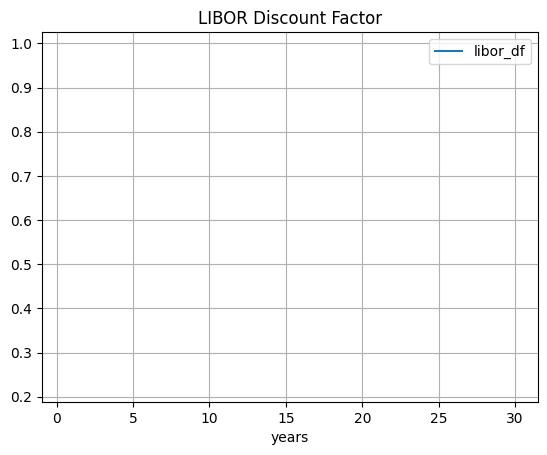

In [15]:
irs.plot(x='years',y='libor_df')
plt.title("LIBOR Discount Factor")
plt.grid(True)
plt.show()

## Question 3
Solving for FRA will be similar to swaps, however the starting points will differ
**LIBOR forward swaps**
$$
\sum^N_{i=s+1} D_o(0,T_i) \times \Delta_i \times IRS_{forward} - \sum^N_{i=s+1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$
**OIS forward swaps**
$$\begin{aligned}
OIS_{forward} &= 
            \frac{D_o(0,T_{s})-D_o(0,T_{N})}
                    {\Delta_i  \sum^N_{i=s+1}D_o(0,T_{i})} \\
            &= 
            \frac{D_o(0,T_{s})-D_o(0,T_{N})}
                    {\Delta_i  \left[ \sum^s_{i=0}D_o(0,T_{i}) - \sum^N_{i=0}D_o(0,T_{i}) \right]} \\
\end{aligned}$$

where $s$ is the start of the rate agreement and N is maturity.

Create a new df for annual OIS cumsum df

In [16]:
ois_annual = ois.loc[range(1,len(ois),2)]
ois_annual['cumsum_df'] = ois_annual.df.cumsum()
ois_annual.reset_index(inplace=True,drop=True)
ois_annual.f = ois_annual.f.fillna(method='bfill')
ois_annual.head(5)

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2678/2863027421.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ois_annual.f = ois_annual.f.fillna(method='bfill')


,years,Rate,df,Tenor,Product,f,cumsum_df
0,1.0,0.00300,0.997009,1y,OIS,0.003493,0.997009
1,2.0,0.00325,0.993531,2y,OIS,0.003495,1.990540
2,3.0,0.00335,0.990015,3y,OIS,0.003545,2.980555
3,4.0,0.00350,0.986117,4y,OIS,0.003946,3.966672
4,5.0,0.00360,0.982184,5y,OIS,0.003996,4.948856


In [17]:
start =10 
tenor = 10


In [18]:
def payer_irs_fwd_swap(fwd_swap_rate, start=1, i=1, irs=irs):
    """
    Return value of forward payer swap starting from year 1 ahead
    Parameters:
        fwd_swap_rate:
        start: in years, 
        i: tenor in years, 
        irs: Dataframe of IRS rates, libor/OIS df
    """
    # fix_leg = cumsum_ois_df * 0.5 * IRS
    # for forward starting, deduct the starting period DF
    cumsum_ois_df = irs.loc[irs['years'] <= start+i, 'ois_df'].sum() \
                        - irs.loc[irs['years'] <= start, 'ois_df'].sum()
    fix_leg = cumsum_ois_df * 0.5 * fwd_swap_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = 0
    for j in range(int(start*2),int((start+i)*2)):
        # print(j, irs.at[j,'libor_df'])
        float_leg += irs.at[j,'ois_df'] * (irs.at[j-1,'libor_df']-irs.at[j,'libor_df']) \
                                            / irs.at[j,'libor_df']

    return fix_leg - float_leg

payer_irs_fwd_swap(.032007, 1, 1, irs)

nan

In [19]:
# instantiate FRA table
fra = pd.DataFrame({'start' : [1]*5 + [5]*5 + [10]*5,
                          'tenor' : [1,2,3,5,10]*3, 
                          'f_irs': [np.nan]*15, 
                          'f_ois': [np.nan]*15})

# iterate through table and get FRA
for idx, row in fra.iterrows():
    start = row['start']
    tenor = row['tenor']
    tenor_days = 360*tenor
    L = 1

    # compute forward Libor
    fra.at[idx, 'f_irs'] = fsolve(payer_irs_fwd_swap,
                                      guess,
                                      args=(start,
                                            tenor,
                                            irs))
    
    # compute forward OIS
    for i in range(int(start+1), int(start+tenor+1)):     
        f = ois_annual.loc[ois_annual.years == i].f.values[0]
        L *= (1+f/360)**360
    fra.at[idx, 'f_ois'] = 360*(L**(1/tenor_days)-1)

fra

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_2678/54455377.py:15: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fra.at[idx, 'f_irs'] = fsolve(payer_irs_fwd_swap,


,start,tenor,f_irs,f_ois
0,1,1,0.226632,0.003495
1,1,2,0.226632,0.003520
2,1,3,0.226632,0.003662
3,1,5,0.226632,0.003997
4,1,10,0.226632,0.004734
5,5,1,0.226632,0.005003
6,5,2,0.226632,0.005003
7,5,3,0.226632,0.005171
8,5,5,0.226632,0.005306
9,5,10,0.226632,0.005567
